Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 4.2) 강남역 맛집 리뷰로 알아보는 감성 분류

### 바로가기

- [<Step1. 크롤링> : 카카오맵 리뷰 크롤링](#<Step1.-크롤링>-:-카카오맵-리뷰-크롤링)
    - [카카오맵 크롤링]
    - [맛집 리뷰 정보 크롤링]
- [<Step2. 전처리> : TF-IDF를 이용한 핵심어 추출](#<Step2.-전처리>-:-TF\-IDF를-이용한-핵심어-추출)
    - [형태소 추출하기]
    - [분류 모델의 학습 데이터로 변환하기]
- [<Step3. 분류> : 긍정 부정 리뷰 분류하기](#<Step3.-분류>-:-긍정-부정-리뷰-분류하기)
    - [분류 모델링]
    - [분류 모델 개선]
- [<Step4. 활용> : 중요 키워드 분석](#<Step4.-활용>-:-중요-키워드-분석)
    - [회귀 모델의 피처 영향력 추출]
    - [중요 피처의 형태소]

-----

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# <Step1. 크롤링> : 카카오맵 리뷰 크롤링 

### [카카오맵 개발자도구 화면]

![앱 생성 페이지](img/1.png)

-----

In [31]:
from selenium import webdriver
from bs4 import BeautifulSoup
import re
import time

# brew 로 설치된 chromedriver의 path (Mac)
path = '/usr/local/bin/chromedriver'

# 윈도우용 크롬 웹드라이버 실행 경로 (Windows)
excutable_path = 'chromedriver.exe'

# 크롤링할 사이트 주소를 정의합니다.
source_url = "https://map.kakao.com/"

# 크롬 드라이버를 사용합니다 (맥은 첫 줄, 윈도우는 두번째 줄 실행)
# driver = webdriver.Chrome(path)
driver = webdriver.Chrome(executable_path=excutable_path)

# 카카오 지도에 접속합니다
driver.get(source_url)

# 검색창에 검색어를 입력합니다
searchbox = driver.find_element_by_xpath("//input[@id='search.keyword.query']")
searchbox.send_keys("영통 맛집")

# 검색버튼을 눌러서 결과를 가져옵니다
searchbutton = driver.find_element_by_xpath("//button[@id='search.keyword.submit']")
driver.execute_script("arguments[0].click();", searchbutton)

# 검색 결과를 가져올 시간을 기다립니다
time.sleep(2)

# 검색 결과의 페이지 소스를 가져옵니다
html = driver.page_source

# BeautifulSoup을 이용하여 html 정보를 파싱합니다
soup = BeautifulSoup(html, "html.parser")
moreviews = soup.find_all(name="a", attrs={"class":"moreview"})

# a태그의 href 속성을 리스트로 추출하여, 크롤링 할 페이지 리스트를 생성합니다.
page_urls = []
for moreview in moreviews:
    page_url = moreview.get("href")
    print(page_url)
    page_urls.append(page_url)

# 크롤링에 사용한 브라우저를 종료합니다.
driver.close()

https://place.map.kakao.com/9968737
https://place.map.kakao.com/26626836
https://place.map.kakao.com/1617467808
https://place.map.kakao.com/7975283
https://place.map.kakao.com/1234435101
https://place.map.kakao.com/19539402
https://place.map.kakao.com/873631161
https://place.map.kakao.com/25634322
https://place.map.kakao.com/652695946
https://place.map.kakao.com/27412069
https://place.map.kakao.com/22927362
https://place.map.kakao.com/1051286767
https://place.map.kakao.com/2068159256
https://place.map.kakao.com/852221639
https://place.map.kakao.com/1798961498
https://place.map.kakao.com/615360935
https://place.map.kakao.com/26612580
https://place.map.kakao.com/25768091


-----

### [맛집 리뷰 정보 크롤링]

![앱 생성 페이지](img/2.png)

-----

In [32]:
columns = ['score', 'review']
df = pd.DataFrame(columns=columns)

# driver = webdriver.Chrome(path)  # for Mac
driver = webdriver.Chrome(executable_path=excutable_path)  # for Windows
for page_url in page_urls:
    
    # 상세보기 페이지에 접속합니다
    driver.get(page_url)
    time.sleep(2)
    
    # 첫 페이지 리뷰를 크롤링합니다
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    contents_div = soup.find(name="div", attrs={"class":"evaluation_review"})
    
    # 별점을 가져옵니다.
    rates = contents_div.find_all(name="em", attrs={"class":"num_rate"})
    
    # 리뷰를 가져옵니다.
    reviews = contents_div.find_all(name="p", attrs={"class":"txt_comment"})
    
    for rate, review in zip(rates, reviews):
        row = [rate.text[0], review.find(name="span").text]
        series = pd.Series(row, index=df.columns)
        df = df.append(series, ignore_index=True)
    
    # 2-5페이지의 리뷰를 크롤링합니다
    for button_num in range(2, 6):
        # 오류가 나는 경우(리뷰 페이지가 없는 경우), 수행하지 않습니다.
        try:
            another_reviews = driver.find_element_by_xpath("//a[@data-page='" + str(button_num) + "']")
            another_reviews.click()
            time.sleep(2)
            
            # 페이지 리뷰를 크롤링합니다
            html = driver.page_source
            soup = BeautifulSoup(html, 'html.parser')
            contents_div = soup.find(name="div", attrs={"class":"evaluation_review"})

            # 별점을 가져옵니다.
            rates = contents_div.find_all(name="em", attrs={"class":"num_rate"})

            # 리뷰를 가져옵니다.
            reviews = contents_div.find_all(name="p", attrs={"class":"txt_comment"})

            for rate, review in zip(rates, reviews):
                row = [rate.text[0], review.find(name="span").text]
                series = pd.Series(row, index=df.columns)
                df = df.append(series, ignore_index=True)
        except:
            break    
driver.close()

In [33]:
# 4점 이상의 리뷰는 긍정 리뷰, 3점 이하의 리뷰는 부정 리뷰로 평가합니다.
df['y'] = df['score'].apply(lambda x: 1 if float(x) > 3 else 0)
print(df.shape)
df.head()

(420, 3)


,score,review,y
0,5,"라운딩 후 기력보충으로 장어로 정해서 먹었는데 메뉴선택, 매장선택이 좋았습니다",1
1,5,날이더워고민했는데 그래도 맛있게 먹고나니 기분좋습니다.,1
2,5,실하고 좋네요~~ 오랜만에 가족식사 나왔어요. 사람 많고 맛있었어요,1
3,5,청명산장어오면 다른곳못가죠 ㅎ,1
4,5,너무너무맛있어요~~ 몸보신해야 살죠~,1


In [52]:
# df.to_csv("review_data2.csv",encoding='utf-8-sig', index=False)
df.to_csv("review_data2.csv", index=False)

-----

# <Step2. 전처리> : TF-IDF를 이용한 핵심어 추출

### [형태소 추출하기]

##### 한글 텍스트로 전처리

In [2]:
df = pd.read_csv("review_data2.csv")

In [3]:
import re

# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거
def text_cleaning(text):
    # 한글의 정규표현식으로 한글만 추출합니다.
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
#     result = hangul.sub('', text)
    result = hangul.sub('', str(text))
    return result

In [55]:
df.head()

,score,review,y
0,5,"라운딩 후 기력보충으로 장어로 정해서 먹었는데 메뉴선택, 매장선택이 좋았습니다",1
1,5,날이더워고민했는데 그래도 맛있게 먹고나니 기분좋습니다.,1
2,5,실하고 좋네요~~ 오랜만에 가족식사 나왔어요. 사람 많고 맛있었어요,1
3,5,청명산장어오면 다른곳못가죠 ㅎ,1
4,5,너무너무맛있어요~~ 몸보신해야 살죠~,1


In [4]:
#결측시
print(df.isnull().sum())
df

score      0
review    87
y          0
dtype: int64


,score,review,y
0,5,"라운딩 후 기력보충으로 장어로 정해서 먹었는데 메뉴선택, 매장선택이 좋았습니다",1
1,5,날이더워고민했는데 그래도 맛있게 먹고나니 기분좋습니다.,1
2,5,실하고 좋네요~~ 오랜만에 가족식사 나왔어요. 사람 많고 맛있었어요,1
3,5,청명산장어오면 다른곳못가죠 ㅎ,1
4,5,너무너무맛있어요~~ 몸보신해야 살죠~,1
...,...,...,...
415,5,언니가 너무 먹고싶어해서 애기 둘 데리고 힘들게 갔는데 사장님이 배려 많이해주셔서 ...,1
416,2,맛있긴한데 가격을 진심 심각할 정도로올리심 분명 19년초엔 2만원이었는데.. 그때도...,0
417,2,맛은 당연 곱창 이니 평타는 치고 가격이 너무ㅋㅋ.... 이동네 곱창집 잘하는곳 또...,0
418,2,"맛없진 않았는데 1인분 2만5천원은 비싸기도 하고, 그 값에 기다릴만큼 엄청 맛있었...",0


In [57]:
# park.dropna(subset=['위도', '경도'],inplace=True) # '위도', '경도' 에 nan 있는 row 삭제
df.dropna(subset=['review'], inplace=True)
df

,score,review,y
0,5,"라운딩 후 기력보충으로 장어로 정해서 먹었는데 메뉴선택, 매장선택이 좋았습니다",1
1,5,날이더워고민했는데 그래도 맛있게 먹고나니 기분좋습니다.,1
2,5,실하고 좋네요~~ 오랜만에 가족식사 나왔어요. 사람 많고 맛있었어요,1
3,5,청명산장어오면 다른곳못가죠 ㅎ,1
4,5,너무너무맛있어요~~ 몸보신해야 살죠~,1
...,...,...,...
415,5,언니가 너무 먹고싶어해서 애기 둘 데리고 힘들게 갔는데 사장님이 배려 많이해주셔서 ...,1
416,2,맛있긴한데 가격을 진심 심각할 정도로올리심 분명 19년초엔 2만원이었는데.. 그때도...,0
417,2,맛은 당연 곱창 이니 평타는 치고 가격이 너무ㅋㅋ.... 이동네 곱창집 잘하는곳 또...,0
418,2,"맛없진 않았는데 1인분 2만5천원은 비싸기도 하고, 그 값에 기다릴만큼 엄청 맛있었...",0


In [5]:
#정규식 사용 예제
import re
text = "에러 1122 : 레퍼런스 오류\n 에러 1033: 아규먼트 오류"
regex = re.compile("에러 1033")
mo = regex.search(text)
if mo != None:
    print(mo.group()) 

에러 1033


In [6]:
# 함수를 적용하여 리뷰에서 한글만 추출합니다.
df = pd.read_csv("review_data2.csv")
df['ko_text'] = df['review'].apply(lambda x: text_cleaning(x))
del df['review']

# 한 글자 이상의 텍스트를 가지고 있는 데이터만 추출합니다
df = df[df['ko_text'].str.len() > 0]
df.head()

,score,y,ko_text
0,5,1,라운딩 후 기력보충으로 장어로 정해서 먹었는데 메뉴선택 매장선택이 좋았습니다
1,5,1,날이더워고민했는데 그래도 맛있게 먹고나니 기분좋습니다
2,5,1,실하고 좋네요 오랜만에 가족식사 나왔어요 사람 많고 맛있었어요
3,5,1,청명산장어오면 다른곳못가죠 ㅎ
4,5,1,너무너무맛있어요 몸보신해야 살죠


-----

##### 형태소 단위로 추출

In [ ]:
import sys
sys.version

In [7]:
from konlpy.tag import Okt

# konlpy라이브러리로 텍스트 데이터에서 형태소를 추출합니다.
def get_pos(x):
    tagger = Okt()
    pos = tagger.pos(x)
    pos = ['{}/{}'.format(word,tag) for word, tag in pos]
    return pos

# 형태소 추출 동작을 테스트합니다.
result = get_pos(df['ko_text'].values[3])
print(result)

['청명산/Noun', '장어/Noun', '오면/Verb', '다른/Modifier', '곳/Noun', '못/VerbPrefix', '가죠/Verb', 'ㅎ/KoreanParticle']


-----

### [분류 모델의 학습 데이터로 변환하기]

##### corpus index 생성하기

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환합니다.
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_pos(x))
X = index_vectorizer.fit_transform(df['ko_text'].tolist())

In [9]:
X.shape

(332, 2335)

In [10]:
print(str(index_vectorizer.vocabulary_)[:100]+"..")

{'라운딩/Noun': 663, '후/Noun': 2313, '기력/Noun': 292, '보충/Noun': 1018, '으로/Josa': 1627, '장어/Noun': 1773,..


In [11]:
print(df['ko_text'].values[0])
print(X[0])

라운딩 후 기력보충으로 장어로 정해서 먹었는데 메뉴선택 매장선택이 좋았습니다
  (0, 663)	1
  (0, 2313)	1
  (0, 292)	1
  (0, 1018)	1
  (0, 1627)	1
  (0, 1773)	1
  (0, 673)	1
  (0, 1828)	1
  (0, 1164)	1
  (0, 836)	1
  (0, 865)	1
  (0, 1175)	2
  (0, 810)	1
  (0, 1648)	1
  (0, 1872)	1


-----

##### TF-IDF로 변환

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer

# TF-IDF 방법으로, 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환합니다.
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

In [13]:
print(X.shape)
print(X[0])

(332, 2335)
  (0, 2313)	0.2516980388851735
  (0, 1872)	0.26505308161923713
  (0, 1828)	0.28387595716308556
  (0, 1773)	0.19698142859831358
  (0, 1648)	0.10416349022967666
  (0, 1627)	0.16662425047205034
  (0, 1175)	0.503396077770347
  (0, 1164)	0.20473656752846156
  (0, 1018)	0.28387595716308556
  (0, 865)	0.2091611446786119
  (0, 836)	0.20473656752846156
  (0, 810)	0.2195201206072614
  (0, 673)	0.1935411199040217
  (0, 663)	0.28387595716308556
  (0, 292)	0.28387595716308556


-----

# <Step3. 분류> : 긍정 부정 리뷰 분류하기

### [분류 모델링]

##### 데이터셋 분리

In [14]:
from sklearn.model_selection import train_test_split

y = df['y']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
print(x_train.shape)
print(x_test.shape)

(232, 2335)
(100, 2335)


-----

##### Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 로지스틱 회귀모델을 학습합니다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 로지스틱 회귀모델의 성능을 평가합니다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.60
Precision : 0.600
Recall : 1.000
F1 : 0.750


In [16]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix를 출력합니다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[ 0 40]
 [ 0 60]]


AUC : 0.861


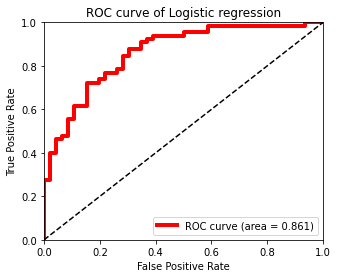

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC를 계산합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve 그래프를 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

------

# <Step4. 활용> : 중요 키워드 분석

### [회귀 모델의 피처 영향력 추출]

<BarContainer object of 2335 artists>

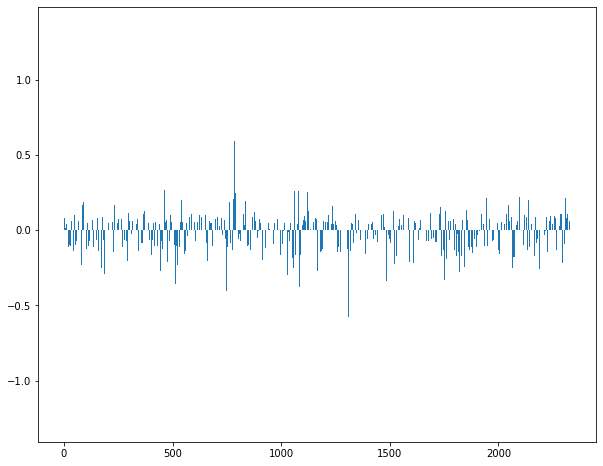

In [17]:
# 학습한 회귀 모델의 계수를 출력합니다.
plt.rcParams['figure.figsize'] = [10, 8]
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

In [18]:
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

[(1.3516192390166488, 778), (0.9855165205420249, 2013), (0.5923761469075278, 785), (0.49089450410254026, 1773), (0.4889954784924478, 1104)]
[(-0.5761779163210459, 1310), (-0.607249102222077, 1579), (-0.8652455335316548, 709), (-1.049562718836889, 1631), (-1.2749323144613218, 450)]


-----

### [중요 피처의 형태소]

In [19]:
# 회귀 모델의 계수를 높은 순으로 정렬합니다. 
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)

In [20]:
# 회귀 모델의 계수를 index_vectorizer에 맵핑하여, 어떤 형태소인지 출력할 수 있게 합니다.
invert_index_vectorizer = {v: k for k, v in index_vectorizer.vocabulary_.items()}

# 계수가 높은 순으로, 피처에 형태소를 맵핑한 결과를 출력합니다. 계수가 높은 피처는 리뷰에 긍정적인 영향을 주는 형태소라고 할 수 있습니다.
print(str(invert_index_vectorizer)[:100]+'..')

{663: '라운딩/Noun', 2313: '후/Noun', 292: '기력/Noun', 1018: '보충/Noun', 1627: '으로/Josa', 1773: '장어/Noun',..


In [21]:
# 상위 20개 긍정 형태소를 출력합니다.
for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

맛있어요/Adjective 1.3516192390166488
최고/Noun 0.9855165205420249
맛있음/Adjective 0.5923761469075278
장어/Noun 0.49089450410254026
빵/Noun 0.4889954784924478
갑니다/Verb 0.4881845508927478
도/Josa 0.45339428013067934
좋아요/Adjective 0.43871827082258696
맛있고/Adjective 0.37833412297617913
광교/Noun 0.37066748353685486
기/Noun 0.3694418414282517
요리/Noun 0.36329632396204486
추천/Noun 0.3628935891508538
굿/Noun 0.3582023722555006
다/Adverb 0.35130424302292323
정말/Noun 0.3434001860187167
초밥/Noun 0.33946836150971055
에요/Josa 0.3313990029489989
인정/Noun 0.33000353118098635
잘/Verb 0.3058596331823073


In [22]:
# 상위 20개 부정 형태소를 출력합니다.
for coef in coef_pos_index[-20:]:
    print(invert_index_vectorizer[coef[1]], coef[0])

한/Josa -0.38123020889424886
최악/Noun -0.3895655381605166
맛/Noun -0.40408956039177407
것/Noun -0.4243764106603821
테이블/Noun -0.42465595272179874
질/Noun -0.42673265896435003
맛있는거에요/Adjective -0.4294242631225001
못/VerbPrefix -0.4335638120737923
페이/Noun -0.43428746829402476
별로/Noun -0.44673809292986727
불친절/Noun -0.483787969572494
좀/Noun -0.5105467186304352
요/Josa -0.5345628494466629
가세/Noun -0.5402589185297731
등심/Noun -0.5651774163239038
쏘/Verb -0.5761779163210459
왜/Noun -0.607249102222077
만/Josa -0.8652455335316548
은/Josa -1.049562718836889
는/Josa -1.2749323144613218


-----

### `[미니 퀴즈 - 4.3]`
- `피처 영향력에 따라 정렬된 형태소에서, 품사별 긍정 형태소 10개와 부정 형태소 10개를 탐색해 보세요.` 
    - “/”로 구분되어있는 정보를 활용하여 품사별 형태소를 추출할 수 있습니다.

In [23]:
noun_list = []
adjective_list = []

# 명사, 형용사별로 계수가 높은 상위 10개의 형태소를 추출합니다. 이는 리뷰에 긍정적인 영향을 주는 명사와 형용사를 순위별로 살펴보는 것이 됩니다.
for coef in coef_pos_index[:100]:
    pos_category = invert_index_vectorizer[coef[1]].split("/")[1]
    if pos_category == "Noun":
        noun_list.append((invert_index_vectorizer[coef[1]], coef[0]))
    elif pos_category == "Adjective":
        adjective_list.append((invert_index_vectorizer[coef[1]], coef[0]))

In [25]:
# 상위 10개의 명사를 출력합니다.
noun_list[:10]

[('최고/Noun', 1.909065385635278),
 ('가성/Noun', 0.5314590777828826),
 ('육즙/Noun', 0.5116651519478432),
 ('추천/Noun', 0.45501949410180387),
 ('비/Noun', 0.45428785157702345),
 ('곱/Noun', 0.44812479266494415),
 ('완전/Noun', 0.3931212412536321),
 ('냉면/Noun', 0.3816815075003937),
 ('명/Noun', 0.3649611052837822),
 ('존맛/Noun', 0.3635650127476783)]

In [24]:
# 상위 10개의 형용사를 출력합니다.
adjective_list[:10]

[('맛있어요/Adjective', 1.3516192390166488),
 ('맛있음/Adjective', 0.5923761469075278),
 ('좋아요/Adjective', 0.43871827082258696),
 ('맛있고/Adjective', 0.37833412297617913),
 ('괜찮았어요/Adjective', 0.30227298554979504),
 ('깔끔하고/Adjective', 0.2970939626189223),
 ('좋았어요/Adjective', 0.2667701626611678),
 ('친절해요/Adjective', 0.26520325324211025),
 ('맛있어여/Adjective', 0.25219840135449),
 ('훌륭합니다/Adjective', 0.2446749358071234)]